## Тема 3. Связь бизнес-показателей и DS-метрик

In [214]:
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt

### Задания

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта

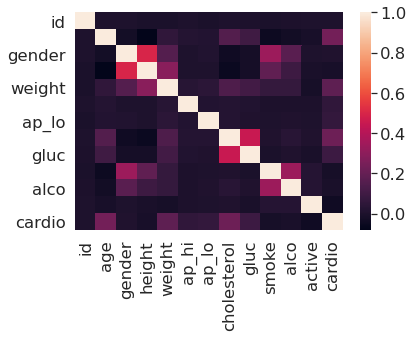

In [124]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)
sns.heatmap(df.corr());

In [125]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

In [127]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.key]

class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[[self.key]]

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []
    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self
    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X['col_'] = 0
            return X[self.columns]

In [128]:
real_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

real_transformers = []
cat_transformers = []
base_transformers = []

for real_col in real_cols:
    transformer = Pipeline([
        ('selector', NumberSelector(key=real_col)),
        ('standard', StandardScaler())
    ])
    real_transformers.append((real_col, transformer))

for cat_col in cat_cols:
    cat_transformer = Pipeline([
        ('selector', ColumnSelector(key=cat_col)),
        ('ohe', OHEEncoder(key=cat_col))
    ])
    cat_transformers.append((cat_col, cat_transformer))

for base_col in base_cols:
    base_transformer = Pipeline([
        ('selector', NumberSelector(key=base_col))
    ])
    base_transformers.append((base_col, base_transformer))

In [129]:
feats = FeatureUnion(real_transformers+cat_transformers+base_transformers)
feature_pocessing = Pipeline([('feats', feats)])

feature_pocessing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

In [241]:
def build_clf(features, classifier, X_train, y_train):
    clf = Pipeline([
        ('features', features),
        ('classifier', classifier) 
    ])

    cv_scores = cross_val_score(clf, X_train, y_train, cv=15, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
    print(f'CV score is {cv_score}+-{cv_score_std}')

    clf.fit(X_train, y_train)
    y_score = clf.predict_proba(X_test)[:, 1]
    return y_score

In [220]:
def calc_metrics(y_test, y_score, beta=1, verbose=False):

    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (1+beta**2)*(precision*recall) / (beta**2*precision + recall)

    ix = np.argmax(fscore)
    if verbose:
        print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix],
                                                                                fscore[ix],
                                                                                precision[ix],
                                                                                recall[ix])) 
    return precision[ix], recall[ix], fscore[ix]

In [232]:
def plot_roc_curve(y_test, y_score, lw=2):
    sns.set(font_scale=0.9)
    sns.set_color_codes("muted")

    plt.figure(figsize=(5, 4))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)

    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show();

## KNeighborsClassifier

In [196]:
y_score_knn = build_clf(feats, 
                        classifier=KNeighborsClassifier(), 
                        X_train=X_train, 
                        y_train=y_train)
y_score_knn

CV score is 0.6919332197099132+-0.006141439937486001


array([0.2, 0.2, 0. , ..., 0.2, 0.8, 0.6])

In [188]:
calc_metrics(y_test, y_score_knn, beta=1)

Best Threshold=0.400000, F-Score=0.686, Precision=0.588, Recall=0.822


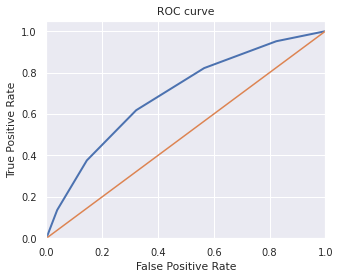

1

In [215]:
plot_roc_curve(y_test, y_score_knn)

## GradientBoostingClassifier

In [251]:
%%time
y_score_gb = build_clf(feats, 
                       classifier=GradientBoostingClassifier(random_state=42), 
                       X_train=X_train, 
                       y_train=y_train)
y_score_gb

CV score is 0.8025690215208525+-0.007645325851736689
CPU times: user 2min 14s, sys: 206 ms, total: 2min 14s
Wall time: 2min 14s


In [191]:
calc_metrics(y_test, y_score_gb, beta=1)

Best Threshold=0.394947, F-Score=0.740, Precision=0.698, Recall=0.788


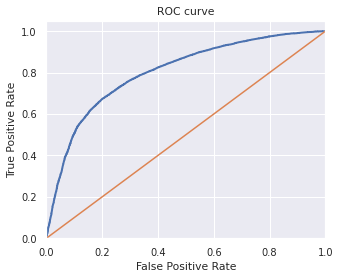

1

In [201]:
plot_roc_curve(y_test, y_score_gb)

## DecisionTreeClassifier

In [209]:
y_score_dt = build_clf(feats, 
                       classifier=DecisionTreeClassifier(random_state=42), 
                       X_train=X_train, 
                       y_train=y_train)
y_score_dt

CV score is 0.6354159765153677+-0.007821303747441534


array([0., 0., 0., ..., 0., 1., 0.])

Best Threshold=1.000000, F-Score=0.632, Precision=0.633, Recall=0.629


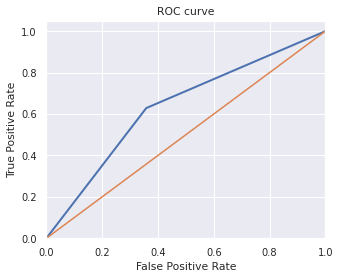

1

In [211]:
calc_metrics(y_test, y_score_dt, beta=0.7)
plot_roc_curve(y_test, y_score_dt)

## Logistic Regression

In [212]:
y_score_logreg = build_clf(feats, 
                           LogisticRegression(penalty='l2', max_iter=131, random_state = 42),
                           X_train, 
                           y_train)

calc_metrics(y_test, y_score_logreg)

CV score is 0.786753017724367+-0.007954793990832189
Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838


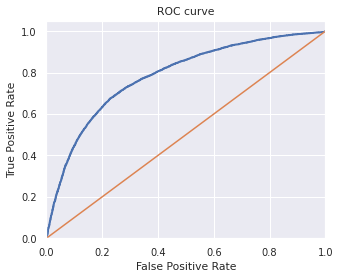

1

In [213]:
plot_roc_curve(y_test, y_score_logreg)

3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)

In [223]:
precision_logreg, recall_logreg, fscore_logreg = calc_metrics(y_test, y_score_logreg)
precision_dt, recall_dt, fscore_dt = calc_metrics(y_test, y_score_dt)
precision_gb, recall_gb, fscore_gb = calc_metrics(y_test, y_score_gb)
precision_knn, recall_knn, fscore_knn = calc_metrics(y_test, y_score_knn)

d = {'auc': [roc_auc_score(y_test, y_score_logreg),
             roc_auc_score(y_test, y_score_dt), 
             roc_auc_score(y_test, y_score_gb), 
             roc_auc_score(y_test, y_score_knn)],
     
     'precision': [precision_logreg, 
                   precision_dt, 
                   precision_gb, 
                   precision_knn],
     
     'recall': [recall_logreg, 
                recall_dt, 
                recall_gb, 
                recall_knn],
     
     'f_score': [fscore_logreg, 
                 fscore_dt, 
                 fscore_gb, 
                 fscore_knn]
    }

In [224]:
pd.DataFrame(data=d, index=['LogisticRegression', 
                            'DecisionTreeClassifier', 
                            'GradientBoostingClassifier',
                            'KNearestNeighbors'])

,auc,precision,recall,f_score
LogisticRegression,0.784035,0.647431,0.837558,0.730323
DecisionTreeClassifier,0.635325,0.496000,1.000000,0.663102
GradientBoostingClassifier,0.802615,0.697848,0.788134,0.740248
KNearestNeighbors,0.694088,0.588468,0.821889,0.685863


4. сделать выводы о том, какая модель справилась с задачей лучше других

_С классификацией лучше всех справилась модель с градиентным спуском_

5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

_roc_auc_curve следует использовать, когда имеется примерно одинаковое количество наблюдений для каждого класса.
<br>precision_recall_curve следует использовать при наличии дисбаланса класса от среднего до большого._


In [231]:
df['cardio'].value_counts() # таргет сбалансирован

0    35021
1    34979
Name: cardio, dtype: int64

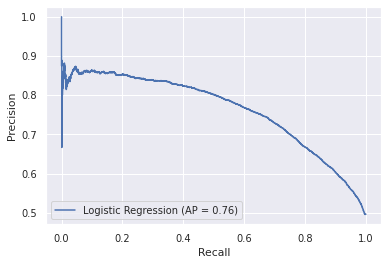

In [248]:
from sklearn.metrics import plot_precision_recall_curve

clf = Pipeline([
        ('features', feats),
        ('classifier', LogisticRegression(penalty='l2', max_iter=131, random_state = 42)) 
    ])
lr = clf.fit(X_train, y_train)
plot_precision_recall_curve(lr, X_test, y_test, name = 'Logistic Regression');

### Ссылки
1. https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/
2. https://en.wikipedia.org/wiki/Receiver_operating_characteristic